In [1]:
import random
import numpy as np
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import fasttext.util
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import re

In [2]:
dataset = pd.read_csv('/home/tina/Desktop/–°–µ–º–µ—Å—Ç—Ä_3/NLP/eng_toxic_full_df.csv')
columns = ['comment_text', 'neutral', 'toxic_not_threat', 'toxic_threat']
dataset = dataset[columns]
dataset


comment_text  neutral  \
0       Explanation\nWhy the edits made under my usern...        1   
1       D'aww! He matches this background colour I'm s...        1   
2       Hey man, I'm really not trying to edit war. It...        1   
3       "\nMore\nI can't make any real suggestions on ...        1   
4       You, sir, are my hero. Any chance you remember...        1   
...                                                   ...      ...   
159566  ":::::And for the second time of asking, when ...        1   
159567  You should be ashamed of yourself \n\nThat is ...        1   
159568  Spitzer \n\nUmm, theres no actual article for ...        1   
159569  And it looks like it was actually you who put ...        1   
159570  "\nAnd ... I really don't think you understand...        1   

        toxic_not_threat  toxic_threat  
0                      0             0  
1                      0             0  
2                      0             0  
3                      0             0  
4                      0             0  
...                  ...           ...  
159566                 0             0  
159567                 0             0  
159568                 0             0  
159569                 0             0  
159570                 0             0  

[159571 rows x 4 columns]

In [3]:
x = dataset['comment_text']
y = dataset[['neutral', 'toxic_not_threat', 'toxic_threat']]
print(y['neutral'].value_counts())
print(y['toxic_not_threat'].value_counts())
print(y['toxic_threat'].value_counts())

neutral
1    143346
0     16225
Name: count, dtype: int64
toxic_not_threat
0    143824
1     15747
Name: count, dtype: int64
toxic_threat
0    159093
1       478
Name: count, dtype: int64


In [4]:
neutral_df = dataset[dataset['neutral'] == 1].sample(n=15000)
toxic_not_threat_df = dataset[dataset['toxic_not_threat'] == 1].sample(n=15000)
toxic_threat_df = dataset[dataset['toxic_threat'] == 1]
balanced_dataset = pd.concat([neutral_df, toxic_not_threat_df, toxic_threat_df], axis=0)
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_dataset

comment_text  neutral  \
0      "\n\nThe dick who is editing with policy is al...        0   
1      This is a stupid page. Please expand the artic...        0   
2      "Yes, second imposter in a few days. But what ...        1   
3      I can't believe Wiki is stupid enough as to ma...        0   
4      AHHHH THANKS! I was rackin my brain the whole ...        1   
...                                                  ...      ...   
30473  Fuck off you ass!Fuck off you ass!Fuck off you...        0   
30474  "\nThis is a Wikipedia page about engines (pow...        1   
30475  I like it alot. Should we lose the guy standin...        1   
30476  Hey Aaron Brennenman, Eat shit and Die, sincer...        0   
30477                REDIRECT Talk:American Landrace pig        0   

       toxic_not_threat  toxic_threat  
0                     1             0  
1                     1             0  
2                     0             0  
3                     1             0  
4                     0             0  
...                 ...           ...  
30473                 1             0  
30474                 0             0  
30475                 0             0  
30476                 1             0  
30477                 1             0  

[30478 rows x 4 columns]

In [5]:
x = balanced_dataset['comment_text']
y = balanced_dataset[['neutral', 'toxic_not_threat', 'toxic_threat']]
print(y['neutral'].value_counts())
print(y['toxic_not_threat'].value_counts())
print(y['toxic_threat'].value_counts())

neutral
0    15478
1    15000
Name: count, dtype: int64
toxic_not_threat
0    15478
1    15000
Name: count, dtype: int64
toxic_threat
0    30000
1      478
Name: count, dtype: int64


**–î–∞—Ç–∞—Å–µ—Ç –Ω–µ—Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω—ã–π, —Ç–æ–ª—å–∫–æ 478 –ø—Ä–∏–º–µ—Ä–æ–≤ –Ω–∞ 3 –∫–ª–∞—Å—Å. –í —Ç–æ –∂–µ –≤—Ä–µ–º—è —Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏–µ –¥–∞—Ç–∞—Å–µ—Ç–∞ –æ–±—ä–µ–º–æ–º –≤ 1500-2000 –¥–µ–º–æ–Ω—Å—Ç—Ä–∏—Ä—É–µ—Ç –º–µ–Ω–µ–µ —É–¥–æ–≤–ª–µ—Ç–≤–æ—Ä–∏—Ç–µ–ª—å–Ω—ã–µ –º–µ—Ç—Ä–∏–∫–∏ –∫–∞—á–µ—Å—Ç–≤–∞, —á–µ–º –Ω–µ—Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç, –Ω–æ –±–æ–ª—å—à–µ–≥–æ –æ–±—ä–µ–º–∞**

In [6]:
y = y.idxmax(axis=1).map({'neutral': 0, 'toxic_not_threat': 1, 'toxic_threat': 2}).values
print("labels shape:", y.shape)
print("–ü—Ä–∏–º–µ—Ä –º–µ—Ç–æ–∫:", y[:5])

labels shape: (30478,)
–ü—Ä–∏–º–µ—Ä –º–µ—Ç–æ–∫: [1 1 0 1 0]


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)


In [8]:
y_test.shape

(6096,)

In [9]:
x_test.shape

(6096,)

**–ó–¥–µ—Å—å –º—ã –≤—ã–Ω—É–∂–¥–µ–Ω—ã —Ä–∞–∑–±–∏–≤–∞—Ç—å –Ω–∞ —á–∞–Ω–∫–∏ –±–µ–∑ –∏–∑ –ø–æ–¥–∞—á–∏ –≤ –∏—Ç–µ—Ä–∞—Ç–∏–≤–Ω—É—é —Ñ—É–Ω–∫—Ü–∏—é, —Ç.–∫. –ª—é–±–æ–π –∏—Ç–µ—Ä–∞—Ç–æ—Ä –∑–∞–≤–∏—Å–∞–µ—Ç. –¢–∞–∫–∏–º –æ–±—Ä–∞–∑–æ–º, –±—É–¥–µ–º —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–∏—Ä–æ–≤–∞—Ç—å –∫–∞–∂–¥—ã–π —á–∞–Ω–∫ –≤ —ç–±–µ–¥–¥–∏–Ω–≥–∏ —á–µ—Ä–µ–∑ –æ—Ç–¥–µ–ª—å–Ω—ã–π –∑–∞–ø—É—Å–∫**

In [10]:
x_train

20631    QED As long as we're tattling to the teacher, ...
18878      Viridae you suck Mike's cunt nostril discharge!
9278     Why the hell was this page deleted? Bloody van...
11375    Hey Jac16888, how very chickenshit of you to t...
29509    Sigh*\n\nSo you just went ahead and removed th...
                               ...                        
7972     Hey\nGo fuck yourself, cunt. Lick your mother'...
30391    "\n\nWikipedia:Featured picture candidates/Fal...
18813    "\n\nHey\nThe following is a message that I fo...
2211     You must have a lot of kleenex by your compute...
27388    "\n\nwow you are dumb. and that is NOT an atta...
Name: comment_text, Length: 24382, dtype: object

<!-- # === FastText ===
print("\n=== FastText ===")
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

def get_text_embedding(text, model, max_len=500):
    words = text.strip().split()[:max_len]  # –û–±—Ä–µ–∑–∞–µ–º –¥–æ max_len —Å–ª–æ–≤
    word_vectors = [model.get_word_vector(w) for w in words if w]
    if len(word_vectors) == 0:
        return np.zeros((max_len, model.get_dimension()))  # [max_len, 300]
    word_vectors = np.array(word_vectors)  # [len(words), 300]
    pad_len = max_len - len(word_vectors)
    word_vectors = np.pad(word_vectors, ((0, pad_len), (0, 0)), mode='constant')  # [max_len, 300]
    return word_vectors

X_train_ft = np.array([get_text_embedding(s, ft) for s in x_train])  # [N, max_len, 300] -->


In [11]:
x_1 = x_train[:2000]
x_2 = x_train[2000:4000]
x_3 = x_train[4000:6000]
x_4 = x_train[6000:8000]
x_5 = x_train[8000:10000]
x_6 = x_train[10000:12000]
x_7 = x_train[12000:14000]
x_8 = x_train[14000:16000]
x_9 = x_train[16000:18000]
x_10 = x_train[18000:20000]
x_11 = x_train[20000:22000]
x_12 = x_train[22000:24000]

**–î–∞–ª–µ–µ –ø—Ä–æ–≤–æ–¥–∏–º –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫—É –¥–∞—Ç–∞—Å–µ—Ç–∞ –∏ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ —á–∞–Ω–∫–æ–≤ –≤ —ç–º–±–µ–¥–¥–∏–Ω–≥–∏**

In [12]:
# === FastText ===
print("\n=== FastText ===")
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

def get_text_embedding(text, model, max_len=50):
    text = text.lower()
    text = re.sub(r"[^–∞-—è—ëa-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    words = text.strip().split()[:max_len]  # –û–±—Ä–µ–∑–∞–µ–º –¥–æ max_len —Å–ª–æ–≤
    word_vectors = [model.get_word_vector(w) for w in words if w]
    if len(word_vectors) == 0:
        return np.zeros((max_len, model.get_dimension()))  # [max_len, 300]
    word_vectors = np.array(word_vectors)  # [len(words), 300]
    pad_len = max_len - len(word_vectors)
    word_vectors = np.pad(word_vectors, ((0, pad_len), (0, 0)), mode='constant')  # [max_len, 300]
    return word_vectors


=== FastText ===


In [13]:
X_train_ft_1 = np.array([get_text_embedding(s, ft) for s in x_1])

In [14]:
X_train_ft_2 = np.array([get_text_embedding(s, ft) for s in x_2])

In [15]:
X_train_ft_3 = np.array([get_text_embedding(s, ft) for s in x_3])

In [16]:
X_train_ft_4 = np.array([get_text_embedding(s, ft) for s in x_4])

In [17]:
X_train_ft_5 = np.array([get_text_embedding(s, ft) for s in x_5])

In [18]:
X_train_ft_6 = np.array([get_text_embedding(s, ft) for s in x_6])

In [19]:
X_train_ft_7 = np.array([get_text_embedding(s, ft) for s in x_7])

In [20]:
X_train_ft_8 = np.array([get_text_embedding(s, ft) for s in x_8])

In [21]:
X_train_ft_9 = np.array([get_text_embedding(s, ft) for s in x_9])

In [22]:
X_train_ft_10 = np.array([get_text_embedding(s, ft) for s in x_10])

In [23]:
X_train_ft_11 = np.array([get_text_embedding(s, ft) for s in x_11])

In [24]:
X_train_ft_12 = np.array([get_text_embedding(s, ft) for s in x_12])

In [26]:
print([get_text_embedding(s, ft).shape for s in x_12[:5]])


[(50, 300), (50, 300), (50, 300), (50, 300), (50, 300)]


In [28]:
X_train_ft = np.concatenate(
    [X_train_ft_1, X_train_ft_2, X_train_ft_3, X_train_ft_4, 
     X_train_ft_5, X_train_ft_6, X_train_ft_7, X_train_ft_8, 
     X_train_ft_9, X_train_ft_10, X_train_ft_11, X_train_ft_12],
    axis=0
)

In [29]:
X_train_ft

array([[[-1.37850475e-02,  4.49780524e-02, -1.02881029e-01, ...,
          1.49011984e-01, -1.72202945e-01,  7.84196928e-02],
        [-7.57918134e-03, -2.51861900e-01, -3.77689779e-01, ...,
          2.45352730e-01, -9.30264369e-02,  1.02733530e-01],
        [ 4.01744097e-02, -7.54821524e-02, -1.70764476e-01, ...,
          1.28862560e-01, -2.55123265e-02, -9.08786338e-03],
        ...,
        [-6.37750775e-02,  1.62931904e-01,  8.19036290e-02, ...,
          2.44460091e-01,  2.73179971e-02,  2.25536488e-02],
        [ 1.07891530e-01, -4.41231616e-02,  1.34061828e-01, ...,
          3.64399344e-01, -6.35679811e-02, -1.63635716e-01],
        [ 2.20759623e-02,  4.97831553e-02,  8.75587389e-02, ...,
         -8.18165243e-02, -3.10543254e-02, -4.62635756e-02]],

       [[-2.50594448e-02, -1.29243582e-02,  2.16444731e-02, ...,
          8.23112484e-03, -6.69747069e-02, -1.51969669e-02],
        [ 1.07891530e-01, -4.41231616e-02,  1.34061828e-01, ...,
          3.64399344e-01, -6.35679811e

In [30]:
X_test_ft = np.array([get_text_embedding(s, ft) for s in x_test])    # [M, 500, 300]


In [31]:
print(X_train_ft[0][:10, :10])

[[-0.01378505  0.04497805 -0.10288103 -0.02506758  0.07986296  0.03554565
  -0.06179228  0.05130907 -0.04978871 -0.00457895]
 [-0.00757918 -0.2518619  -0.37768978 -0.0577099  -0.05636054 -0.03647275
  -0.0202911  -0.03977192 -0.01115279 -0.02524362]
 [ 0.04017441 -0.07548215 -0.17076448  0.09889671 -0.06959968 -0.03826058
   0.14142025 -0.03885336  0.02082691 -0.02676404]
 [-0.00757918 -0.2518619  -0.37768978 -0.0577099  -0.05636054 -0.03647275
  -0.0202911  -0.03977192 -0.01115279 -0.02524362]
 [-0.22641462 -0.02829784  0.03269786 -0.06704076 -0.3381909   0.10943558
  -0.15156898 -0.14285415  0.03621052  0.09130385]
 [-0.0063294  -0.47312373  0.1201752  -0.09970269  0.18209514 -0.15243442
  -0.32113984 -0.34530884  0.4031888   0.09720431]
 [-0.02046151  0.02256993  0.07257503  0.06947276 -0.04279188 -0.06888237
   0.00296307 -0.06066    -0.02530357  0.02729249]
 [ 0.00468114  0.02812425 -0.02963145 -0.01081373 -0.06200187 -0.05324718
  -0.09798437  0.09703769 -0.0863658  -0.04250967]


In [32]:
# === TextDataset ===
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # [N, max_len, 300]
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32
train_dataset = TextDataset(X_train_ft, y_train)

In [33]:
test_dataset = TextDataset(X_test_ft, y_test)

In [34]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [35]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)

**–í–æ–∑—å–º–µ–º CNN –º–æ–¥–µ–ª—å. –ë—É–¥–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –¥–≤–∞ –≤–∏–¥–∞ –ø—É–ª–ª–∏–Ω–≥–∞, –∫–æ—Ç–æ—Ä—ã–µ –ø–æ—Ç–µ–Ω—Ü–∏–∞–ª—å–Ω–æ –∏–∑–≤–ª–µ–∫—É—Ç –∑–Ω–∞—á–∏–º—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –∏–∑ –∫–æ–Ω—Ç–µ–∫—Å—Ç–∞ –Ω–∞ —Ä–∞–∑–Ω—ã—Ö —É—Ä–æ–≤–Ω—è—Ö. –ó–∞–º–µ—Ç–∏–º –∑–¥–µ—Å—å, —á—Ç–æ —Ç–∞–∫–∞—è —Å–≤—è–∑–∫–∞ —Å –ø—É–ª–ª–∏–Ω–≥–∞–º–∏ —É–ª—É—á—à–∞–µ—Ç –±–∞–∑–æ–≤—É—é —Å–≤–µ—Ä—Ç–∫—É –≤ —á–∞—Å—Ç–∏ accuracy –ø–æ—á—Ç–∏ –Ω–∞ 30%. –≠—Ç–æ –æ–±—ä—è—Å–Ω—è–µ—Ç—Å—è –≤—ã—Å–æ–∫–æ–π –∑–Ω–∞—á–∏–º–æ—Å—Ç—å—é –∫–æ–Ω—Ç–µ–∫—Å—Ç–∞ –¥–ª—è –¥–∞–Ω–Ω–æ–≥–æ —Ç–∏–ø–∞ –∑–∞–¥–∞—á**

In [36]:
# === TextCNN_FT ===
class TextCNN_FT(nn.Module):
    def __init__(self, embed_dim=300, num_classes=3, kernel_sizes=[3,4,5], num_filters=100, dropout=0.5):
        super().__init__()
        self.convs = nn.ModuleList([nn.Conv1d(embed_dim, num_filters, k) for k in kernel_sizes])
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(num_filters * len(kernel_sizes) * 2)  # *2 –¥–ª—è max+avg pooling
        self.fc = nn.Linear(num_filters * len(kernel_sizes) * 2, num_classes)

    def forward(self, x):
        # x: [B, L, E]
        x = x.permute(0, 2, 1)  # [B, E, L]
        convs = [F.relu(conv(x)) for conv in self.convs]  # [B, F, L-k+1]
        pools_max = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in convs]  # [B, F]
        pools_avg = [F.avg_pool1d(c, c.size(2)).squeeze(2) for c in convs]  # [B, F]
        pools = [torch.cat([pm, pa], dim=1) for pm, pa in zip(pools_max, pools_avg)]  # [B, 2F]
        x = torch.cat(pools, dim=1)  # [B, 2F * len(kernel_sizes)]
        x = self.dropout(self.bn(x))
        return self.fc(x)

In [37]:
model = TextCNN_FT(embed_dim=300, num_classes=3)
print(model)

TextCNN_FT(
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (bn): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=600, out_features=3, bias=True)
)


**v2 (—Ä–∞—Å—à–∏—Ä–µ–Ω–Ω–∞—è –≤–µ—Ä—Å–∏—è —Å Residual connections, –∑–∞–¥–µ–π—Å—Ç–≤–æ–≤–∞–Ω–Ω–∞—è –Ω–∞ –¥—Ä—É–≥–∏—Ö –ø—Ä–æ–µ–∫—Ç–∞—Ö –≤ –ø—Ä–æ—à–ª–æ–º –≥–æ–¥—É), –º–æ–∂–Ω–æ –∑–∞–ø—É—Å—Ç–∏—Ç—å –Ω–∞ –≤—Ç–æ—Ä–æ–º –ø—Ä–æ—Ö–æ–¥–µ, –º–æ–∂–µ—Ç –¥–∞—Ç—å –Ω–µ–±–æ–ª—å—à–æ–π –ø—Ä–∏—Ä–æ—Å—Ç, –Ω–æ –Ω–µ—Å—É—â–µ—Å—Ç–≤–µ–Ω–Ω—ã–π**

In [43]:
class TextCNN_FT(nn.Module):
    def __init__(self, embed_dim=300, num_classes=3, kernel_sizes=[3, 4, 5], num_filters=128, dropout=0.3):
        super().__init__()
        # –ü–µ—Ä–≤—ã–π –Ω–∞–±–æ—Ä —Å–≤—ë—Ä—Ç–æ—á–Ω—ã—Ö —Å–ª–æ—ë–≤
        self.convs1 = nn.ModuleList([nn.Conv1d(embed_dim, num_filters, k) for k in kernel_sizes])
        self.bn1 = nn.ModuleList([nn.BatchNorm1d(num_filters) for _ in kernel_sizes])
        # –í—Ç–æ—Ä–æ–π –Ω–∞–±–æ—Ä —Å–≤—ë—Ä—Ç–æ—á–Ω—ã—Ö —Å–ª–æ—ë–≤
        self.convs2 = nn.ModuleList([nn.Conv1d(num_filters, num_filters, k) for k in kernel_sizes])
        self.bn2 = nn.ModuleList([nn.BatchNorm1d(num_filters) for _ in kernel_sizes])
        # Dropout –∏ BatchNorm –¥–ª—è –ø–æ–ª–Ω–æ—Å–≤—è–∑–Ω—ã—Ö —Å–ª–æ—ë–≤
        self.dropout = nn.Dropout(dropout)
        self.bn_fc = nn.BatchNorm1d(num_filters * len(kernel_sizes) * 2)  # *2 –¥–ª—è max+avg pooling
        # –ü–æ–ª–Ω–æ—Å–≤—è–∑–Ω—ã–µ —Å–ª–æ–∏
        self.fc1 = nn.Linear(num_filters * len(kernel_sizes) * 2, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # x: [B, L, E]
        x = x.permute(0, 2, 1)  # [B, E, L]
        # –ü–µ—Ä–≤—ã–π —Å–≤—ë—Ä—Ç–æ—á–Ω—ã–π —Å–ª–æ–π
        convs1 = [F.relu(self.bn1[i](conv(x))) for i, conv in enumerate(self.convs1)]  # [B, F, L-k+1]
        # –í—Ç–æ—Ä–æ–π —Å–≤—ë—Ä—Ç–æ—á–Ω—ã–π —Å–ª–æ–π —Å –æ—Å—Ç–∞—Ç–æ—á–Ω—ã–º–∏ —Å–≤—è–∑—è–º–∏
        convs2 = []
        for i, (c, conv) in enumerate(zip(convs1, self.convs2)):
            c2 = F.relu(self.bn2[i](conv(c)))
            # –û—Å—Ç–∞—Ç–æ—á–Ω–∞—è —Å–≤—è–∑—å (–µ—Å–ª–∏ —Ä–∞–∑–º–µ—Ä—ã —Å–æ–≤–ø–∞–¥–∞—é—Ç)
            if c2.size(2) == c.size(2):
                c2 = c2 + c  # Residual connection
            convs2.append(c2)
        # Max –∏ Avg –ø—É–ª–∏–Ω–≥
        pools_max = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in convs2]  # [B, F]
        pools_avg = [F.avg_pool1d(c, c.size(2)).squeeze(2) for c in convs2]  # [B, F]
        pools = [torch.cat([pm, pa], dim=1) for pm, pa in zip(pools_max, pools_avg)]  # [B, 2F]
        x = torch.cat(pools, dim=1)  # [B, 2F * len(kernel_sizes)]
        # –ü–æ–ª–Ω–æ—Å–≤—è–∑–Ω—ã–µ —Å–ª–æ–∏
        x = self.dropout(self.bn_fc(x))
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [44]:
model = TextCNN_FT(embed_dim=300, num_classes=3)
print(model)

TextCNN_FT(
  (convs1): ModuleList(
    (0): Conv1d(300, 128, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 128, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 128, kernel_size=(5,), stride=(1,))
  )
  (bn1): ModuleList(
    (0-2): 3 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convs2): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (1): Conv1d(128, 128, kernel_size=(4,), stride=(1,))
    (2): Conv1d(128, 128, kernel_size=(5,), stride=(1,))
  )
  (bn2): ModuleList(
    (0-2): 3 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (bn_fc): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)


In [45]:
# === –§—É–Ω–∫—Ü–∏—è –æ–±—É—á–µ–Ω–∏—è ===
def train_model(model, train_loader, test_loader, epochs=5, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    test_accuracies = []
    
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        
        for X_batch, y_batch in pbar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # [B, max_len, 300], [B]
            optimizer.zero_grad()
            logits = model(X_batch)  # [B, num_classes]
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * X_batch.size(0)
            pbar.set_postfix({"loss": loss.item()})
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                logits = model(X_batch)
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        test_accuracies.append(acc)
        
        print(f"Epoch {epoch}: Train Loss = {epoch_loss:.4f}, Test Accuracy = {acc:.4f}")
    
    # –ì—Ä–∞—Ñ–∏–∫ Loss –∏ Accuracy
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color='tab:red')
    ax1.plot(range(1, epochs+1), train_losses, color='tab:red', marker='o', label='Train Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Test Accuracy', color='tab:blue')
    ax2.plot(range(1, epochs+1), test_accuracies, color='tab:blue', marker='x', label='Test Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    
    fig.tight_layout()
    plt.show()
    
    # Confusion Matrix
    final_cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(final_cm).plot(cmap="Blues")
    plt.show()
    
    return test_accuracies[-1], final_cm

In [46]:
def evaluate(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    running_loss = 0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc="Evaluating"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # [B, max_len, 300], [B]
            logits = model(X_batch)  # [B, num_classes]
            loss = criterion(logits, y_batch)
            running_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    test_loss = running_loss / len(test_loader.dataset)
    test_accuracy = accuracy_score(all_labels, all_preds)
    
    print(f"Test Loss = {test_loss:.4f}, Test Accuracy = {test_accuracy:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues")
    plt.show()
    
    return test_accuracy, cm

Epoch 1/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 205.96it/s, loss=0.134]


Epoch 1: Train Loss = 0.3871, Test Accuracy = 0.8870


Epoch 2/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 218.74it/s, loss=0.19]


Epoch 2: Train Loss = 0.2973, Test Accuracy = 0.8924


Epoch 3/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 221.10it/s, loss=0.282]


Epoch 3: Train Loss = 0.2654, Test Accuracy = 0.8962


Epoch 4/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 225.42it/s, loss=0.208]


Epoch 4: Train Loss = 0.2471, Test Accuracy = 0.9024


Epoch 5/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 219.92it/s, loss=0.0926]


Epoch 5: Train Loss = 0.2249, Test Accuracy = 0.8880


Epoch 6/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 221.67it/s, loss=0.173]


Epoch 6: Train Loss = 0.2077, Test Accuracy = 0.9022


Epoch 7/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 224.83it/s, loss=0.0954]


Epoch 7: Train Loss = 0.1797, Test Accuracy = 0.8960


Epoch 8/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 224.40it/s, loss=0.128]


Epoch 8: Train Loss = 0.1615, Test Accuracy = 0.8975


Epoch 9/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 231.64it/s, loss=0.15]


Epoch 9: Train Loss = 0.1475, Test Accuracy = 0.8998


Epoch 10/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 223.98it/s, loss=0.116]


Epoch 10: Train Loss = 0.1324, Test Accuracy = 0.8939


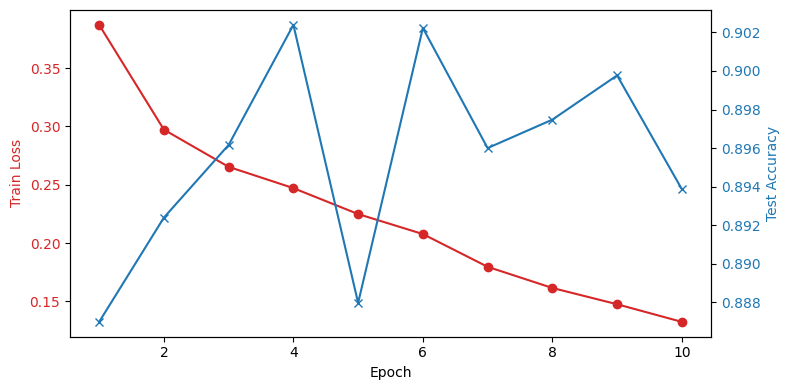

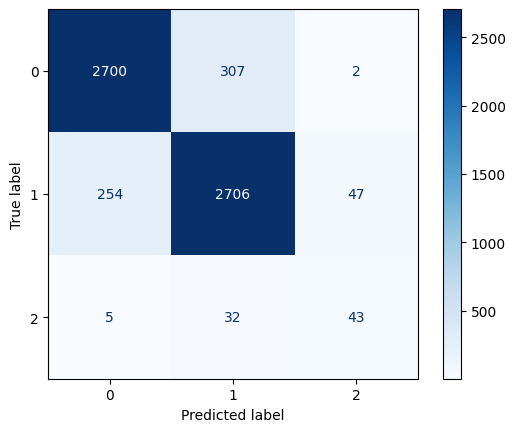

CNN Train Accuracy: 0.8938648293963255


In [47]:
cnn_acc, cnn_cm = train_model(model, train_loader, test_loader, epochs=10, lr=1e-3)
print("CNN Train Accuracy:", cnn_acc)

Evaluating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [00:00<00:00, 508.56it/s]


Test Loss = 0.3471, Test Accuracy = 0.8939


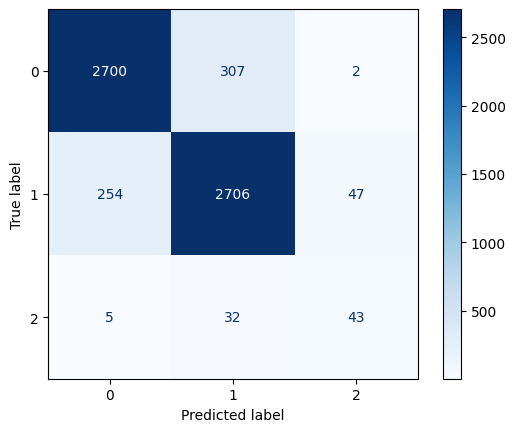

CNN Test Accuracy: 0.8938648293963255


In [49]:
test_acc, test_cm = evaluate(model, test_loader)
print("CNN Test Accuracy:", test_acc)

**–ú–µ—Ç—Ä–∏–∫–∏ –æ—á–µ–Ω—å –±–ª–∏–∑–∫–∏ –∫ 90%, –Ω–æ –≤–æ–∑–º–æ–∂–Ω–æ –¥–ª—è –∫–æ–Ω—Ç–µ–∫—Å—Ç—É–∞–ª—å–Ω—ã—Ö –∑–∞–¥–∞—á RNN —Å hidden —Å–ª–æ—è–º–∏ –ø—Ä–æ–¥–µ–º–æ–Ω—Å—Ç—Ä–∏—Ä—É—é—Ç —Å–µ–±—è –ª—É—á—à–∏–º –æ–±—Ä–∞–∑–æ–º**

**–ü–æ–ø—Ä–æ–±—É–µ–º –¥–≤—É–Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–Ω—É—é RNN, —á—Ç–æ–±—ã –ª—É—á—à–µ —Å—Ö–≤–∞—Ç—ã–≤–∞—Ç—å –∫–æ–Ω—Ç–µ–∫—Å—Ç. –ó–¥–µ—Å—å –ø—Ä–µ–¥–≤–∞—Ä–∏—Ç–µ–ª—å–Ω–æ –∑–∞–º–µ—Ç–∏–º, —á—Ç–æ–±—ã –¥–ª—è –ª—É—á—à–µ–π –ø–µ—Ä—Ñ–æ–º–∞—Ç–∏–≤–Ω–æ—Å—Ç–∏ –º—ã –≤–∑—è–ª–∏ –Ω–µ —Ç–æ–ª—å–∫–æ –≤—ã—Ö–æ–¥ –ø–æ—Å–ª–µ–¥–Ω–µ–≥–æ hidden —Å–ª–æ—è, –ø–æ—Å–∫–æ–ª—å–∫—É –≤ —Ç–∞–∫–æ–º —Å–ª—É—á–∞–µ –º–µ—Ç—Ä–∏–∫–∏ –±—ã–ª–∏ –Ω–µ—É–¥–æ–≤–ª–µ—Ç–≤–æ—Ä–∏—Ç–µ–ª—å–Ω—ã–º–∏, –∞ –≤—ã—Ö–æ–¥—ã —Å–æ –≤—Å–µ—Ö hidden —Å–ª–æ–µ–≤ –∏ –∑–∞—Ç–µ–º –ø—Ä–æ–ø—É—Å–∫–∞–µ–º –∏—Ö —á–µ—Ä–µ–∑ –ø—É–ª–ª–∏–Ω–≥. –¢–∞–∫ —É–¥–∞–ª–æ—Å—å –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–æ –ø–æ–≤—ã—Å–∏—Ç—å –º–µ—Ç—Ä–∏–∫–∏.**

**–°–Ω–∞—á–∞–ª–∞ –ø–æ–ø—Ä–æ–±—É–µ–º LSTM —Å–ª–æ–∏**

In [42]:
class BiLSTM_FT(nn.Module):
    def __init__(self, embed_dim=300, hidden_size=128, num_layers=2, num_classes=3, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers=num_layers, 
                            bidirectional=True, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out, (h, c) = self.lstm(x)  # out: [B, L, hidden_size*2]
        x = torch.max(out, dim=1)[0]  # Max pooling –ø–æ –¥–ª–∏–Ω–µ: [B, hidden_size*2]
        x = self.dropout(x)
        return self.fc(x)

model_lstm = BiLSTM_FT(embed_dim=300, hidden_size=128, num_layers=2, num_classes=len(set(y_train)))
print(model_lstm)

BiLSTM_FT(
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


Epoch 1/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:04<00:00, 176.67it/s, loss=0.253]


Epoch 1: Train Loss = 0.4166, Test Accuracy = 0.8932


Epoch 2/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:04<00:00, 183.82it/s, loss=0.176]


Epoch 2: Train Loss = 0.2897, Test Accuracy = 0.9006


Epoch 3/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:04<00:00, 184.96it/s, loss=0.33]


Epoch 3: Train Loss = 0.2623, Test Accuracy = 0.8950


Epoch 4/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:04<00:00, 183.10it/s, loss=0.279]


Epoch 4: Train Loss = 0.2462, Test Accuracy = 0.9060


Epoch 5/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:04<00:00, 185.30it/s, loss=0.224]


Epoch 5: Train Loss = 0.2319, Test Accuracy = 0.9031


Epoch 6/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:04<00:00, 183.62it/s, loss=0.299]


Epoch 6: Train Loss = 0.2224, Test Accuracy = 0.9031


Epoch 7/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:04<00:00, 182.96it/s, loss=0.0956]


Epoch 7: Train Loss = 0.2073, Test Accuracy = 0.8996


Epoch 8/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:04<00:00, 181.94it/s, loss=0.0796]


Epoch 8: Train Loss = 0.1984, Test Accuracy = 0.8996


Epoch 9/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:04<00:00, 182.70it/s, loss=0.177]


Epoch 9: Train Loss = 0.1808, Test Accuracy = 0.9058


Epoch 10/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:04<00:00, 182.91it/s, loss=0.131]


Epoch 10: Train Loss = 0.1695, Test Accuracy = 0.9032


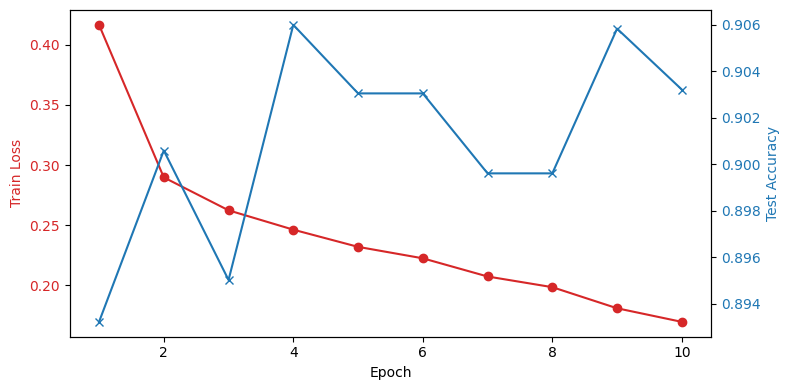

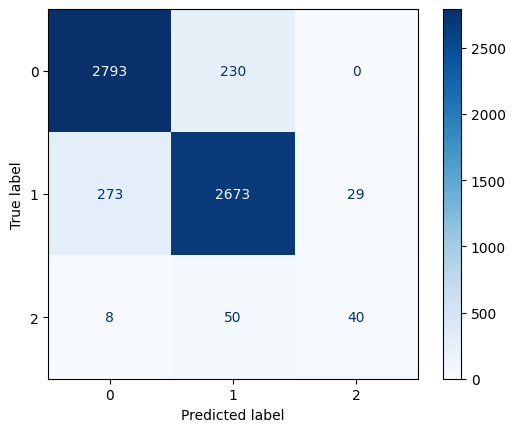

BiLSTM Train Accuracy: 0.9032152230971129


In [43]:
lstm_acc, lstm_cm = train_model(model_lstm, train_loader, test_loader, epochs=10, lr=1e-3)
print("BiLSTM Train Accuracy:", lstm_acc)

test_acc, test_cm = evaluate(model_lstm, test_loader)
print("BiLSTM Test Accuracy:", test_acc)

**–ö–∞–∫ –≤–∏–¥–Ω–æ, LSTM –æ—Ç—Ä–∞–±–∞—Ç—ã–≤–∞–µ—Ç –Ω–µ—Å–∫–æ–ª—å–∫–æ –ª—É—á—à–µ, —á–µ–º CNN. –ü–æ–ª—É—á–∏–ª–∏ –º–µ—Ç—Ä–∏–∫—É > 90%**

**–ü–æ–ø—Ä–æ–±—É–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å GRU —Å–ª–æ–∏. –û–Ω–∏ "–ø—Ä–æ—â–µ", –Ω–æ —á–∞—Å—Ç–æ GRU –æ—Ç—Ä–∞–±–∞—Ç—ã–≤–∞—é—Ç –ª—É—á—à–µ LSTM, –≤–µ—Ä–æ—è—Ç–Ω–æ, –ø–æ—Å–∫–æ–ª—å–∫—É –º–µ–Ω—å—à–µ –∑–∞–ø–æ–º–∏–Ω–∞—é—Ç —à—É–º–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö, –æ–Ω–∏ –±–æ–ª–µ–µ –æ–ø—Ç–∏–º–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ**

In [50]:
class BiGRU_FT(nn.Module):
    def __init__(self, embed_dim=300, hidden_size=128, num_layers=2, num_classes=3, dropout=0.5):
        super().__init__()
        self.gru = nn.GRU(embed_dim, hidden_size, num_layers=num_layers, 
                          bidirectional=True, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.attention = nn.Linear(hidden_size * 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out, h = self.gru(x)  # out: [B, L, hidden_size*2]
        attn_weights = F.softmax(self.attention(out), dim=1)  # [B, L, 1]
        x = torch.sum(out * attn_weights, dim=1)  # [B, hidden_size*2]
        x = self.dropout(x)
        return self.fc(x)
        
model_gru = BiGRU_FT(embed_dim=300, hidden_size=128, num_layers=2, num_classes=len(set(y_train)))
print(model_gru)

BiGRU_FT(
  (gru): GRU(300, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


Epoch 1/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 212.62it/s, loss=0.18]


Epoch 1: Train Loss = 0.3548, Test Accuracy = 0.9003


Epoch 2/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 216.08it/s, loss=0.35]


Epoch 2: Train Loss = 0.2640, Test Accuracy = 0.9017


Epoch 3/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 220.08it/s, loss=0.294]


Epoch 3: Train Loss = 0.2435, Test Accuracy = 0.9067


Epoch 4/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 217.92it/s, loss=0.218]


Epoch 4: Train Loss = 0.2287, Test Accuracy = 0.8991


Epoch 5/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 218.72it/s, loss=0.174]


Epoch 5: Train Loss = 0.2179, Test Accuracy = 0.9094


Epoch 6/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 221.51it/s, loss=0.264]


Epoch 6: Train Loss = 0.2059, Test Accuracy = 0.9042


Epoch 7/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 220.09it/s, loss=0.121]


Epoch 7: Train Loss = 0.1927, Test Accuracy = 0.9055


Epoch 8/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 218.88it/s, loss=0.258]


Epoch 8: Train Loss = 0.1776, Test Accuracy = 0.8980


Epoch 9/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 220.36it/s, loss=0.137]


Epoch 9: Train Loss = 0.1635, Test Accuracy = 0.9011


Epoch 10/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 750/750 [00:03<00:00, 220.94it/s, loss=0.388]


Epoch 10: Train Loss = 0.1445, Test Accuracy = 0.9029


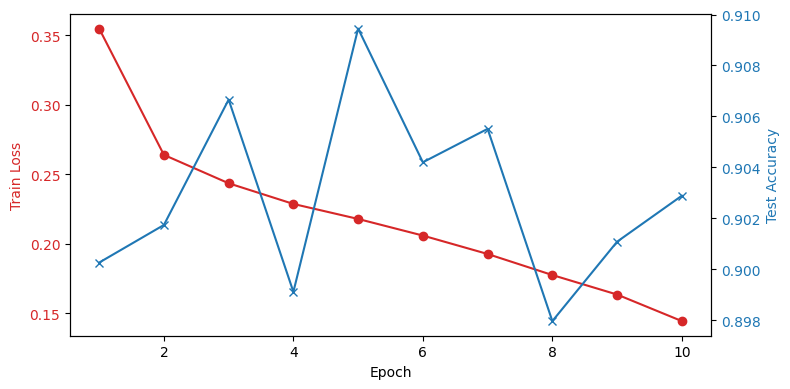

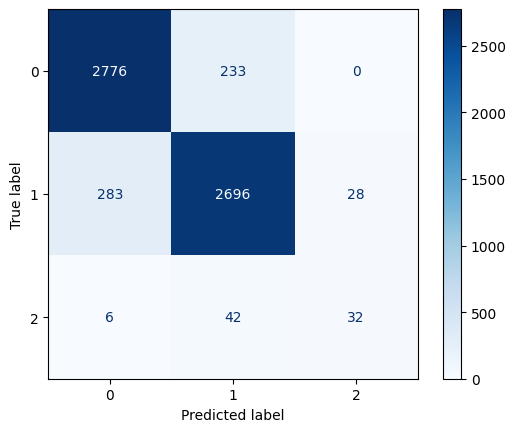

BiGRU Train Accuracy: 0.9028871391076115


In [51]:
# === –ó–∞–ø—É—Å–∫ –æ–±—É—á–µ–Ω–∏—è –∏ –æ—Ü–µ–Ω–∫–∏ –¥–ª—è GRU ===
gru_acc, gru_cm = train_model(model_gru, train_loader, test_loader, epochs=10, lr=1e-3)
print("BiGRU Train Accuracy:", gru_acc)

Evaluating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [00:00<00:00, 505.25it/s]


Test Loss = 0.2792, Test Accuracy = 0.9029


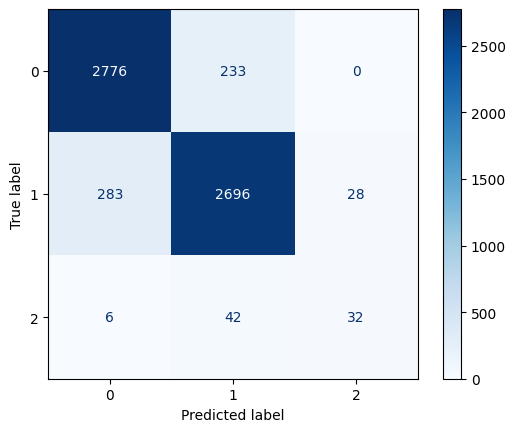

BiGRU Test Accuracy: 0.9028871391076115


In [52]:
test_acc, test_cm = evaluate(model_gru, test_loader)
print("BiGRU Test Accuracy:", test_acc)

**–ú–µ—Ç—Ä–∏–∫–∏, –∫–∞–∫ –º–∏–Ω–∏–º—É–º, –Ω–µ —Ö—É–∂–µ, –∏ —Ç–∞–∫–∂–µ –ø—Ä–µ–≤—ã—à–∞—é—Ç 90%**

**Russian language models**

**–ü–æ–ø—Ä–æ–±—É–µ–º –Ω–∞—Ç—Ä–µ–Ω–∏—Ä–æ–≤–∞—Ç—å –º–æ–¥–µ–ª–∏ –Ω–∞ —Ä—É—Å—Å–∫–æ—è–∑—ã—á–Ω—ã—Ö –¥–∞—Ç–∞—Å–µ—Ç–∞—Ö –∏ –ø–æ—Å–º–æ—Ç—Ä–µ—Ç—å –º–µ—Ç—Ä–∏–∫–∏**

**–î–∞–ª–µ–µ –±—É–¥—É—Ç –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å—Å—è —Ç–µ –∂–µ —Ñ—É–Ω–∫—Ü–∏–∏ –∏ —Ç–µ –∂–µ –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—ã, –ø–æ—ç—Ç–æ–º—É –º–æ—Ç–∏–≤–∏—Ä–æ–≤–∫–∞ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è —Ç–µ—Ö –∏–ª–∏ –∏–Ω—ã—Ö –º–µ—Ç–æ–¥–æ–≤ –∏–¥–µ–Ω—Ç–∏—á–Ω–∞ –∏ –Ω–µ –¥—É–±–ª–∏—Ä—É–µ—Ç—Å—è**

In [1]:
import random
import numpy as np
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import fasttext.util
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import re

In [2]:
dataset = pd.read_csv('/home/tina/Desktop/–°–µ–º–µ—Å—Ç—Ä_3/NLP/rus_toxic_full_df.csv')
dataset


text  neutral  \
0                                    —Å–∫–æ—Ç–∏–Ω–∞! —á—Ç–æ —Å–∫–∞–∑–∞—Ç—å        0   
1       —è —Å–µ–≥–æ–¥–Ω—è –ø—Ä–æ–µ–∑–∂–∞–ª–∞ –ø–æ —Ä–∞–±–æ—á–µ–π –∏ –º–µ–∂–¥—É –¥–æ–º–∞–º–∏ ...        1   
2       –æ—á–µ—Ä–µ–¥–Ω–æ–π –ª–æ—Ö–æ—Ç—Ä–æ–Ω. –∑–∞—á–µ–º –ø—Ä–∏–¥—É–º—ã–≤–∞—Ç—å –æ—á–µ—Ä–µ–¥–Ω–æ...        1   
3       —Ä–µ—Ç—Ä–æ –¥–µ–∂–∞–≤—é ... —Å–ª–æ–∂–Ω–æ –ø–æ–Ω—è—Ç—å —á—É–∂–æ–µ —Å–µ—Ä–¥—Ü–µ , ...        1   
4                 –∞ –∫–æ–≥–¥–∞ –º—ã —Å—Ç–∞—Ç—É—Å –∞–≥—Ä–æ–≥–æ—Ä–æ–¥–∫–∞ –ø–æ–ª—É—á–∏–ª–∏?        1   
...                                                   ...      ...   
248285                       –ø—Ä–∞–≤–∏–ª—å–Ω–æ –≤—Å—ë –ø–æ –ø—è—Ç—å (5)...        1   
248286  —ë–±–∞–Ω–Ω—ã–µ –Ω—É–±—ã –∑–∞—Ö–æ–¥–∏—Ç–µ –Ω–∞ —Å–µ—Ä–≤–µ—Ä –º–æ–π –Ω–∏–∫ _creep...        0   
248287  –∞ —É –º–µ–Ω—è –Ω–∞–≤–µ—Ä–Ω–æ–µ —Ä–µ–∫–æ—Ä–¥ –≤ 1962 –≥–æ–¥—É –≤ —É—á–∏–ª–∏—â–µ...        1   
248288                              —Å–ø–∞—Å–∏–±–æ –≤—Å–µ–º –±–æ–ª—å—à–æ–µ)        1   
248289  –Ω–µ–ª—å–∑—è –ª–∏ —É–≤–µ–ª–∏—á–∏—Ç—å —Ö–æ—Ç—è –±—ã –≤ –¥–≤–∞ —Ä–∞–∑–∞ –Ω–µ–∫–æ—Ç–æ—Ä...        1   

        toxic_threat  toxic_not_threat  
0                  0                 1  
1                  0                 0  
2                  0                 0  
3                  0                 0  
4                  0                 0  
...              ...               ...  
248285             0                 0  
248286             0                 1  
248287             0                 0  
248288             0                 0  
248289             0                 0  

[248290 rows x 4 columns]

In [3]:
x = dataset['text']
y = dataset[['neutral', 'toxic_not_threat', 'toxic_threat']]

print(y['neutral'].value_counts())
print(y['toxic_not_threat'].value_counts())
print(y['toxic_threat'].value_counts())


neutral
1    203685
0     44605
Name: count, dtype: int64
toxic_not_threat
0    215712
1     32578
Name: count, dtype: int64
toxic_threat
0    236263
1     12027
Name: count, dtype: int64


**–ó–¥–µ—Å—å –¥–∞—Ç–∞—Å–µ—Ç –¥–æ–≤–æ–ª—å–Ω–æ —Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω—ã–π, –º–æ–∂–Ω–æ –≤–∑—è—Ç—å –ø–æ 12 000 –ø—Ä–∏–º–µ—Ä–æ–≤ –Ω–∞ –∫–∞–∂–¥—ã–π –∫–ª–∞—Å—Å**

In [4]:
neutral_df = dataset[dataset['neutral'] == 1].sample(n=12000)
toxic_not_threat_df = dataset[dataset['toxic_not_threat'] == 1].sample(n=12000)
toxic_threat_df = dataset[dataset['toxic_threat'] == 1].sample(n=12000)
balanced_dataset = pd.concat([neutral_df, toxic_not_threat_df, toxic_threat_df], axis=0)
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_dataset

text  neutral  \
0      –ø–∏–¥–∞—Ä–∞—Å–∞ —É—Å–∫–∏—Ö —Ä—É–ª—è—Ç –∫–ª–∏—Ç–æ—Ä—ã...!!! https://ok....        0   
1      —Ç—É—Ç —Ö–æ—Ç—å —Å—Ç–∞–≤—å –∫–ª–∞—Å—Å —Ö–æ—Ç—å –Ω–µ —Å—Ç–∞–≤—å! –∞ –≤—Å–µ —Ä–∞–≤–Ω...        0   
2           —Ç—ã –∂–æ–ø–∞ —á—ë—Ä–Ω–∞—è –∫ —Ç–æ–º—É –∂–µ –µ—â—ë –∏ —Ç—É–ø–æ–π –≤–∞–ª–µ–Ω–æ–∫        0   
3      –µ–ª–µ–Ω–∞ –∫–ø–æ–≥–≥ –æ –æ—á –±—ã–ª–∞ –≤ –≤–æ–∑–º–æ–∂–Ω–æ –≤—ã –∑–Ω–∞–∫–æ–º—ã –æ–±...        0   
4                                 –≤—Å–µ–º –±–æ–ª—å—à–æ–µ —Å–ø–∞—Å–∏–±–æÔºÅÔºâ        1   
...                                                  ...      ...   
35995    –∏ –Ω–µ–±–æ–ª—å—à—É—é —â–µ–ø–æ—Ç–∫—É —É–ø—Å –≤ –¥–æ–ª–±–æ–µ–±—ã –æ–≤—Ü—ã –¥–µ—Ä–µ–≤—å—è        0   
35996  –æ–∫—Ä—É–≥–ª–µ–Ω–∏–µ –≤ –ø–æ–ª—å–∑—É –º–∞–≥–∞–∑–∏–Ω–∞, —Å–∫–æ–ª—å–∫–æ –¥–µ–Ω–µ–≥ –Ω–∞...        1   
35997  –Ω–∏ –≤—Å–µ–º –∏–¥—ë—Ç –π–æ–¥, —É –Ω–µ–∫–æ—Ç–æ—Ä—ã—Ö –Ω–∞ –Ω–µ–≥–æ –∞–ª–ª–µ—Ä–≥–∏—è...        1   
35998                            —Å–æ–≥–ª–∞—Å–Ω–∞.–ª—é–¥–∏ –æ–∑–≤–µ—Ä–µ–ª–∏.        1   
35999  —Ç—ã —Å–∞—Ä–∞—Ç–æ–≤ –≤ –≥–ª–∞–∑–∞ –Ω–µ –≤–∏–¥–µ–ª, —Ö–æ—Ö–ª–æ–µ–±–æ—Ç–∏–Ω–∞ —Ñ—Ä–∞–Ω...        0   

       toxic_threat  toxic_not_threat  
0                 0                 1  
1                 0                 1  
2                 0                 1  
3                 1                 0  
4                 0                 0  
...             ...               ...  
35995             0                 1  
35996             0                 0  
35997             0                 0  
35998             0                 0  
35999             0                 1  

[36000 rows x 4 columns]

In [5]:
x = balanced_dataset['text']
y = balanced_dataset[['neutral', 'toxic_not_threat', 'toxic_threat']]
print(y['neutral'].value_counts())
print(y['toxic_not_threat'].value_counts())
print(y['toxic_threat'].value_counts())

neutral
0    24000
1    12000
Name: count, dtype: int64
toxic_not_threat
0    24000
1    12000
Name: count, dtype: int64
toxic_threat
0    24000
1    12000
Name: count, dtype: int64


In [6]:
y

neutral  toxic_not_threat  toxic_threat
0            0                 1             0
1            0                 1             0
2            0                 1             0
3            0                 0             1
4            1                 0             0
...        ...               ...           ...
35995        0                 1             0
35996        1                 0             0
35997        1                 0             0
35998        1                 0             0
35999        0                 1             0

[36000 rows x 3 columns]

In [7]:
y = y.idxmax(axis=1).map({'neutral': 0, 'toxic_not_threat': 1, 'toxic_threat': 2}).values
print("labels shape:", y.shape)
print("–ü—Ä–∏–º–µ—Ä –º–µ—Ç–æ–∫:", y[:5])

labels shape: (36000,)
–ü—Ä–∏–º–µ—Ä –º–µ—Ç–æ–∫: [1 1 1 2 0]


**–î–µ–ª–∏–º —Ç—Ä–µ–π–Ω –∏ —Ç–µ—Å—Ç –ø–æ–ø–æ–ª–∞–º, —á—Ç–æ–±—ã —Ç–µ—Å—Ç–æ–≤–∞—è –≤—ã–±–æ—Ä–∫–∞ –±—ã–ª–∞ —Ä–µ–ø—Ä–µ–∑–µ–Ω—Ç–∞—Ç–∏–≤–Ω–æ–π, –≤ –¥–∞–Ω–Ω–æ–º —Å–ª—É—á–∞–µ —ç—Ç–æ 18000 –ø—Ä–∏–º–µ—Ä–æ–≤ –Ω–∞ —Ç–µ—Å—Ç**

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, shuffle=True)


In [9]:
x_train

26970                                   —É–±–∏—Ç—å —Ç–∞–∫–æ–≥–æ –º–∞–ª–æ!
3942                         –≤–∞—Å —Ç–∞–º —á–µ–º –µ–±–ª–∞–Ω–æ–≤ –æ–ø—ã–ª—è—é—Ç ?
9977                                   –Ω–µ –æ—Ç –±–æ–ª—å—à–æ–≥–æ —É–º–∞üòÇ
8619     –≤—ã –≤–æ–æ–±—â–µ –µ–±–∞–Ω—É–ª–∏—Å—å...—Å–∫–æ—Ä–æ —Ç–æ—á–Ω–æ –æ—à–µ–π–Ω–∏–∫ –æ–¥–µ–Ω...
5594     –Ω–∏–∂–Ω—è—è –¥–∞—Ç–∞, —ç—Ç–æ –¥–∞—Ç–∞ –≤—ã–¥–∞—á–∏ —Å–≤–∏–¥ –≤–∞. —Ç–∞–∫—á—Ç–æ —Å...
                               ...                        
1842            –≤—Ä–µ–º—è —Ä–∞–∑–¥–∞—á–∏ —Ç–∞–∫ –∏ –æ—Å—Ç–∞—ë—Ç—Å—è. –±—É–¥—É –≤–æ–≤—Ä–µ–º—è
23067    –≥–∞–Ω–¥–æ–Ω –∫–æ–Ω–µ—á–Ω–æ —è –±—É–¥—É –ø–æ–º–Ω–∏—Ç—å —ç—Ç–æ –≤—Å—é –∂–∏–∑–Ω—å –∏ ...
6922     –¥–∞ —ç—Ç–æ—Ç –ø—É—Ç–∏–Ω —Å–æ–≤—Å–µ–º –æ—Ö—É–µ–ª... —Å—É–¥–∏—Ç—å —ç—Ç–æ –Ω–µ—á—Ç–æ...
12129    –ø–æ–¥–ª–∏–ª–∏ –∫–µ—Ä–æ—Å–∏–Ω—É –≤ –æ–≥–æ–Ω—å- —Ç–µ–ø–µ—Ä—å –ø—É—Ç–∏–Ω—Å–∫–∏–º –æ–≤—á...
25886    —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç–∞–ª—å–Ω—ã–π –∏–∂ –ø–ª–∞–Ω–µ—Ç–∞ 400 —Å –¥–≤–∏–∂–∫–æ–º 400...
Name: text, Length: 18000, dtype: object

**–ó–¥–µ—Å—å –º—ã –≤—ã–Ω—É–∂–¥–µ–Ω—ã —Ä–∞–∑–±–∏–≤–∞—Ç—å –Ω–∞ —á–∞–Ω–∫–∏ –±–µ–∑ –∏–∑ –ø–æ–¥–∞—á–∏ –≤ –∏—Ç–µ—Ä–∞—Ç–∏–≤–Ω—É—é —Ñ—É–Ω–∫—Ü–∏—é, —Ç.–∫. –ª—é–±–æ–π –∏—Ç–µ—Ä–∞—Ç–æ—Ä –∑–∞–≤–∏—Å–∞–µ—Ç. –¢–∞–∫–∏–º –æ–±—Ä–∞–∑–æ–º, –±—É–¥–µ–º —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–∏—Ä–æ–≤–∞—Ç—å –∫–∞–∂–¥—ã–π —á–∞–Ω–∫ –≤ —ç–±–µ–¥–¥–∏–Ω–≥–∏ —á–µ—Ä–µ–∑ –æ—Ç–¥–µ–ª—å–Ω—ã–π –∑–∞–ø—É—Å–∫**

In [10]:
x_1 = x_train[:2000]
x_2 = x_train[2000:4000]
x_3 = x_train[4000:6000]
x_4 = x_train[6000:8000]
x_5 = x_train[8000:10000]
x_6 = x_train[10000:12000]
x_7 = x_train[12000:14000]
x_8 = x_train[14000:16000]
x_9 = x_train[16000:18000]

In [11]:
x_9

23887        –ø–∏–∑–¥–∏—Ç—å –ø–æ—Ä–∞ —ç—Ç–∏—Ö –ø–æ–ª–∏—Ü–∞–µ–≤ –ø–æ—Ä–∞...–¥–∞–≤–Ω–æ –ø–æ—Ä–∞.
25459                  –µ—Å—Ç–µ—Å—Ç–≤–µ–Ω–Ω–æ –≤–æ –≤—Å–µ–º –≤–∏–Ω–æ–≤–∞—Ç–∞ —Å—Ä–µ–¥–∞.
21867    –æ–Ω–∞ –≤ —É–∫—Ä–∞–∏–Ω–µ.–Ω–∞ 9 –º–∞—è —É—á–∞—Å—Ç–≤–æ–≤–∞–ª–∞ –≤ –∞–≤—Ç–æ–ø—Ä–æ–±–µ...
26820    –∫–æ–≥–¥–∞ —Ç—ã —Å–¥–æ—Ö–Ω–µ—à —à–∞—Ä–ª–æ—Ç–∞–Ω —ë–±–∞–Ω—ã–π .—É–ø—ã—Ä—å –æ—Ç —Å–∞—Ç...
6933     –µ—Å–ª–∏ —ç—Ç–æ –ø—Ä–∞–≤–¥–∞,—è –ø—Ä–µ–∫–ª–æ–Ω—è—é—Å—å –ø–µ—Ä–µ–¥ —Ç–∞–∫–∏–º–∏ –ª—é–¥...
                               ...                        
1842            –≤—Ä–µ–º—è —Ä–∞–∑–¥–∞—á–∏ —Ç–∞–∫ –∏ –æ—Å—Ç–∞—ë—Ç—Å—è. –±—É–¥—É –≤–æ–≤—Ä–µ–º—è
23067    –≥–∞–Ω–¥–æ–Ω –∫–æ–Ω–µ—á–Ω–æ —è –±—É–¥—É –ø–æ–º–Ω–∏—Ç—å —ç—Ç–æ –≤—Å—é –∂–∏–∑–Ω—å –∏ ...
6922     –¥–∞ —ç—Ç–æ—Ç –ø—É—Ç–∏–Ω —Å–æ–≤—Å–µ–º –æ—Ö—É–µ–ª... —Å—É–¥–∏—Ç—å —ç—Ç–æ –Ω–µ—á—Ç–æ...
12129    –ø–æ–¥–ª–∏–ª–∏ –∫–µ—Ä–æ—Å–∏–Ω—É –≤ –æ–≥–æ–Ω—å- —Ç–µ–ø–µ—Ä—å –ø—É—Ç–∏–Ω—Å–∫–∏–º –æ–≤—á...
25886    —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç–∞–ª—å–Ω—ã–π –∏–∂ –ø–ª–∞–Ω–µ—Ç–∞ 400 —Å –¥–≤–∏–∂–∫–æ

**–î–∞–ª–µ–µ –ø—Ä–æ–≤–æ–¥–∏–º –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫—É –¥–∞–Ω–Ω—ã—Ö –∏ –ø—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –Ω–∞—à–∏ –¥–∞–Ω–Ω—ã–µ –≤ —ç–º–±–µ–¥–¥–∏–Ω–≥–∏**

In [12]:
# === FastText ===
print("\n=== FastText ===")
fasttext.util.download_model('ru', if_exists='ignore')
ft = fasttext.load_model('cc.ru.300.bin')

def get_text_embedding(text, model, max_len=50):
    text = text.lower()
    text = re.sub(r"[^–∞-—è—ëa-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    words = text.strip().split()[:max_len]
    word_vectors = [model.get_word_vector(w) for w in words if w]
    if len(word_vectors) == 0:
        return np.zeros((max_len, model.get_dimension()))  # [max_len, 300]
    word_vectors = np.array(word_vectors)  # [len(words), 300]
    pad_len = max_len - len(word_vectors)
    word_vectors = np.pad(word_vectors, ((0, pad_len), (0, 0)), mode='constant')  # [max_len, 300]
    return word_vectors


=== FastText ===


In [13]:
X_train_ft_1 = np.array([get_text_embedding(s, ft) for s in x_1])

In [14]:
X_train_ft_2 = np.array([get_text_embedding(s, ft) for s in x_2])

In [15]:
X_train_ft_3 = np.array([get_text_embedding(s, ft) for s in x_3])

In [16]:
X_train_ft_4 = np.array([get_text_embedding(s, ft) for s in x_4])

In [17]:
X_train_ft_5 = np.array([get_text_embedding(s, ft) for s in x_5])

In [18]:
X_train_ft_6 = np.array([get_text_embedding(s, ft) for s in x_6])

In [19]:
X_train_ft_7 = np.array([get_text_embedding(s, ft) for s in x_7])

In [20]:
X_train_ft_8 = np.array([get_text_embedding(s, ft) for s in x_8])

In [21]:
X_train_ft_9 = np.array([get_text_embedding(s, ft) for s in x_9])

In [22]:
print([get_text_embedding(s, ft).shape for s in x_9[:5]])

[(50, 300), (50, 300), (50, 300), (50, 300), (50, 300)]


In [23]:
X_train_ft = np.concatenate(
    [X_train_ft_1, X_train_ft_2, X_train_ft_3, X_train_ft_4, 
     X_train_ft_5, X_train_ft_6, X_train_ft_7, X_train_ft_8, 
     X_train_ft_9],
    axis=0
)

In [24]:
X_train_ft

array([[[ 2.13465490e-03, -3.14592011e-03, -9.29429103e-03, ...,
         -1.94670446e-02,  3.40633057e-02, -3.30008939e-03],
        [ 5.17563708e-02,  9.47899558e-03,  2.02253647e-02, ...,
          2.75836121e-02, -5.26788048e-02, -3.58344205e-02],
        [ 1.53560471e-02, -4.27011475e-02, -1.04131699e-02, ...,
         -4.96229902e-02, -6.60395771e-02, -1.99417874e-01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.29841775e-01, -6.50196522e-03, -7.11609945e-02, ...,
         -4.42091897e-02, -2.45059550e-01, -8.00090730e-02],
        [ 2.05443315e-02, -1.71633363e-01, -7.19676018e-02, ...,
          2.53604688e-02, -6.78354502e

In [25]:
X_test_ft = np.array([get_text_embedding(s, ft) for s in x_test])    # [M, max_len, 300]
print(X_train_ft[0][:10, :10])  # –ü–µ—Ä–≤—ã–µ 10 —Å–ª–æ–≤, –ø–µ—Ä–≤—ã–µ 10 —ç–ª–µ–º–µ–Ω—Ç–æ–≤

–ü—Ä–∏–º–µ—Ä —ç–º–±–µ–¥–¥–∏–Ω–≥–∞ FastText –¥–ª—è –ø–µ—Ä–≤–æ–≥–æ —Ç–µ–∫—Å—Ç–∞: [[ 0.00213465 -0.00314592 -0.00929429  0.0334738   0.0228604   0.04059345
  -0.00528134 -0.03792536 -0.04602993 -0.00695037]
 [ 0.05175637  0.009479    0.02022536  0.01808274  0.0296282   0.00295898
   0.01422787 -0.02266838 -0.01581611  0.01027999]
 [ 0.01535605 -0.04270115 -0.01041317  0.10524878 -0.03188214 -0.08835521
  -0.04817184  0.08577232 -0.05629525 -0.05624069]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.       

In [26]:
# === TextDataset ===
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # [N, max_len, 300]
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32
train_dataset = TextDataset(X_train_ft, y_train)

In [27]:
test_dataset = TextDataset(X_test_ft, y_test)

In [28]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [29]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [30]:
# === TextCNN_FT ===
class TextCNN_FT(nn.Module):
    def __init__(self, embed_dim=300, num_classes=3, kernel_sizes=[3,4,5], num_filters=100, dropout=0.5):
        super().__init__()
        self.convs = nn.ModuleList([nn.Conv1d(embed_dim, num_filters, k) for k in kernel_sizes])
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(num_filters * len(kernel_sizes) * 2)  # *2 –¥–ª—è max+avg pooling
        self.fc = nn.Linear(num_filters * len(kernel_sizes) * 2, num_classes)

    def forward(self, x):
        # x: [B, L, E]
        x = x.permute(0, 2, 1)  # [B, E, L]
        convs = [F.relu(conv(x)) for conv in self.convs]  # [B, F, L-k+1]
        pools_max = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in convs]  # [B, F]
        pools_avg = [F.avg_pool1d(c, c.size(2)).squeeze(2) for c in convs]  # [B, F]
        pools = [torch.cat([pm, pa], dim=1) for pm, pa in zip(pools_max, pools_avg)]  # [B, 2F]
        x = torch.cat(pools, dim=1)  # [B, 2F * len(kernel_sizes)]
        x = self.dropout(self.bn(x))
        return self.fc(x)

In [31]:
model = TextCNN_FT(embed_dim=300, num_classes=3)
print(model)

TextCNN_FT(
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (bn): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=600, out_features=3, bias=True)
)


In [32]:
# === –§—É–Ω–∫—Ü–∏—è –æ–±—É—á–µ–Ω–∏—è ===
def train_model(model, train_loader, test_loader, epochs=5, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    test_accuracies = []
    
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        
        for X_batch, y_batch in pbar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # [B, max_len, 300], [B]
            optimizer.zero_grad()
            logits = model(X_batch)  # [B, num_classes]
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * X_batch.size(0)
            pbar.set_postfix({"loss": loss.item()})
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                logits = model(X_batch)
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        test_accuracies.append(acc)
        
        print(f"Epoch {epoch}: Train Loss = {epoch_loss:.4f}, Test Accuracy = {acc:.4f}")
    
    # –ì—Ä–∞—Ñ–∏–∫ Loss –∏ Accuracy
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color='tab:red')
    ax1.plot(range(1, epochs+1), train_losses, color='tab:red', marker='o', label='Train Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Test Accuracy', color='tab:blue')
    ax2.plot(range(1, epochs+1), test_accuracies, color='tab:blue', marker='x', label='Test Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    
    fig.tight_layout()
    plt.show()
    
    # Confusion Matrix
    final_cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(final_cm).plot(cmap="Blues")
    plt.show()
    
    return test_accuracies[-1], final_cm

In [33]:
def evaluate(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    running_loss = 0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc="Evaluating"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # [B, max_len, 300], [B]
            logits = model(X_batch)  # [B, num_classes]
            loss = criterion(logits, y_batch)
            running_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    test_loss = running_loss / len(test_loader.dataset)
    test_accuracy = accuracy_score(all_labels, all_preds)
    
    print(f"Test Loss = {test_loss:.4f}, Test Accuracy = {test_accuracy:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues")
    plt.show()
    
    return test_accuracy, cm

Epoch 1/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 240.45it/s, loss=0.399]


Epoch 1: Train Loss = 0.5164, Test Accuracy = 0.8479


Epoch 2/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:01<00:00, 309.17it/s, loss=0.511]


Epoch 2: Train Loss = 0.3605, Test Accuracy = 0.8869


Epoch 3/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:01<00:00, 326.14it/s, loss=0.41]


Epoch 3: Train Loss = 0.3155, Test Accuracy = 0.8735


Epoch 4/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:01<00:00, 332.44it/s, loss=0.205]


Epoch 4: Train Loss = 0.2865, Test Accuracy = 0.8936


Epoch 5/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:01<00:00, 310.53it/s, loss=0.127]


Epoch 5: Train Loss = 0.2533, Test Accuracy = 0.8931


Epoch 6/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:01<00:00, 333.41it/s, loss=0.464]


Epoch 6: Train Loss = 0.2351, Test Accuracy = 0.8921


Epoch 7/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:01<00:00, 321.57it/s, loss=0.199]


Epoch 7: Train Loss = 0.2108, Test Accuracy = 0.8913


Epoch 8/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:01<00:00, 319.75it/s, loss=0.248]


Epoch 8: Train Loss = 0.1945, Test Accuracy = 0.8952


Epoch 9/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:01<00:00, 326.74it/s, loss=0.419]


Epoch 9: Train Loss = 0.1831, Test Accuracy = 0.8969


Epoch 10/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:01<00:00, 340.58it/s, loss=0.137]


Epoch 10: Train Loss = 0.1684, Test Accuracy = 0.8917


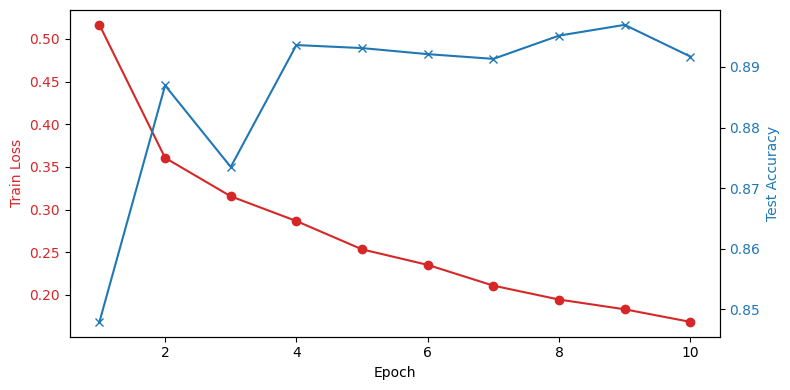

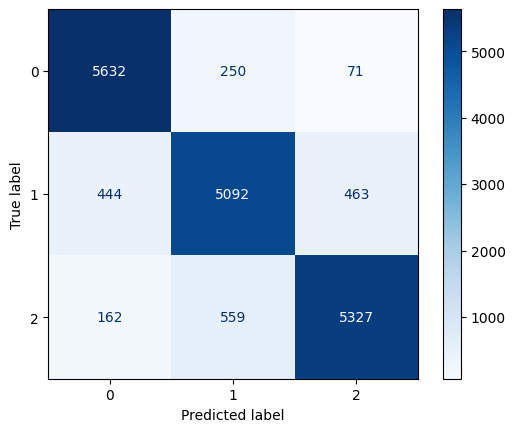

CNN Train Accuracy: 0.8917222222222222


In [34]:
cnn_acc, cnn_cm = train_model(model, train_loader, test_loader, epochs=10, lr=1e-3)
print("CNN Train Accuracy:", cnn_acc)

Evaluating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:00<00:00, 705.38it/s]


Test Loss = 0.3464, Test Accuracy = 0.8917


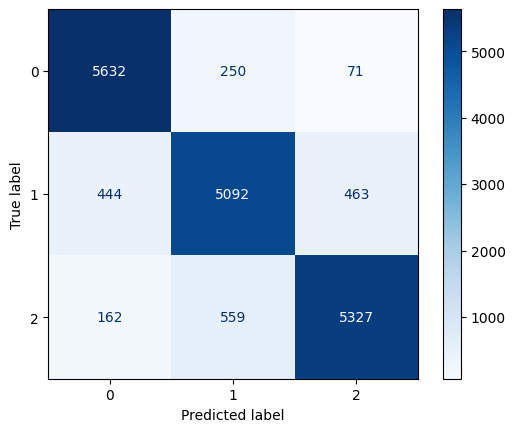

CNN Test Accuracy: 0.8917222222222222


In [35]:
test_acc, test_cm = evaluate(model, test_loader)
print("CNN Test Accuracy:", test_acc)

Epoch 1/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:03<00:00, 181.09it/s, loss=0.815]


Epoch 1: Train Loss = 0.5364, Test Accuracy = 0.8721


Epoch 2/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:03<00:00, 185.16it/s, loss=0.307]


Epoch 2: Train Loss = 0.3173, Test Accuracy = 0.8918


Epoch 3/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:03<00:00, 183.08it/s, loss=0.35]


Epoch 3: Train Loss = 0.2735, Test Accuracy = 0.8998


Epoch 4/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:03<00:00, 185.02it/s, loss=0.0945]


Epoch 4: Train Loss = 0.2420, Test Accuracy = 0.9040


Epoch 5/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:03<00:00, 184.38it/s, loss=0.34]


Epoch 5: Train Loss = 0.2175, Test Accuracy = 0.9015


Epoch 6/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:03<00:00, 183.00it/s, loss=0.049]


Epoch 6: Train Loss = 0.2003, Test Accuracy = 0.9087


Epoch 7/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:03<00:00, 184.29it/s, loss=0.0752]


Epoch 7: Train Loss = 0.1827, Test Accuracy = 0.9069


Epoch 8/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:03<00:00, 184.26it/s, loss=0.0338]


Epoch 8: Train Loss = 0.1661, Test Accuracy = 0.9101


Epoch 9/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:03<00:00, 185.17it/s, loss=0.109]


Epoch 9: Train Loss = 0.1506, Test Accuracy = 0.9091


Epoch 10/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:03<00:00, 184.79it/s, loss=0.0615]


Epoch 10: Train Loss = 0.1346, Test Accuracy = 0.9100


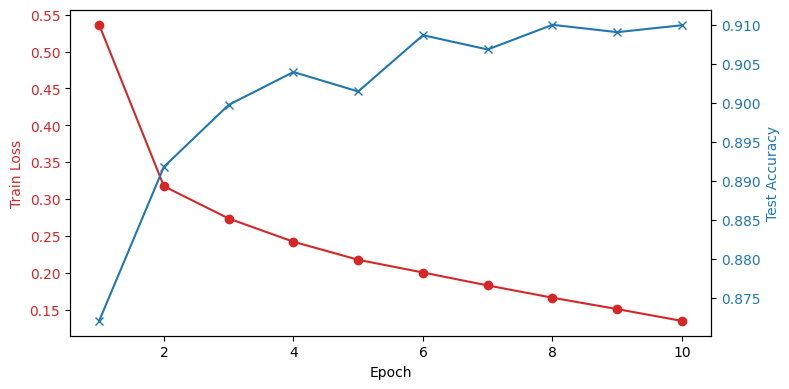

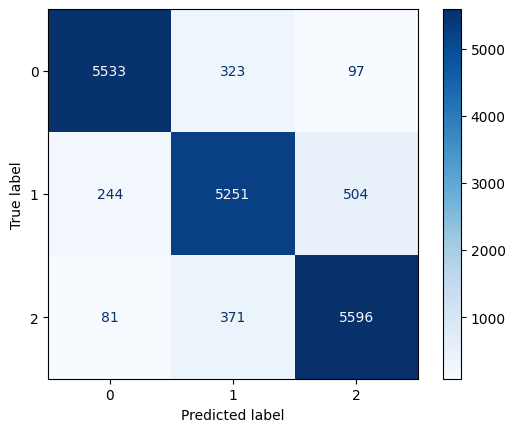

BiLSTM Train Accuracy: 0.91


In [39]:
lstm_acc, lstm_cm = train_model(model_lstm, train_loader, test_loader, epochs=10, lr=1e-3)
print("BiLSTM Train Accuracy:", lstm_acc)

Evaluating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:01<00:00, 415.88it/s]

Test Loss = 0.2838, Test Accuracy = 0.9100


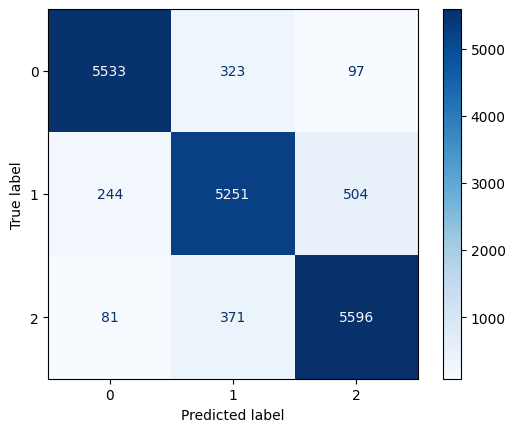

BiLSTM Test Accuracy: 0.91


In [40]:
test_acc, test_cm = evaluate(model_lstm, test_loader)
print("BiLSTM Test Accuracy:", test_acc)

**–¢–∞–∫–∏–º –æ–±—Ä–∞–∑–æ–º, —É–¥–∞–ª–æ—Å—å –¥–æ—Å—Ç–∏–≥–Ω—É—Ç—å –æ—Ç–º–µ—Ç–∫–∏ accuracy > 90%**

Epoch 1/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 199.82it/s, loss=0.275]


Epoch 1: Train Loss = 0.4738, Test Accuracy = 0.8849


Epoch 2/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 221.75it/s, loss=0.416]


Epoch 2: Train Loss = 0.2797, Test Accuracy = 0.9002


Epoch 3/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 222.08it/s, loss=0.0887]


Epoch 3: Train Loss = 0.2421, Test Accuracy = 0.9076


Epoch 4/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 217.84it/s, loss=0.293]


Epoch 4: Train Loss = 0.2178, Test Accuracy = 0.9099


Epoch 5/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 219.40it/s, loss=0.273]


Epoch 5: Train Loss = 0.2036, Test Accuracy = 0.9106


Epoch 6/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 216.87it/s, loss=0.318]


Epoch 6: Train Loss = 0.1849, Test Accuracy = 0.9130


Epoch 7/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 216.75it/s, loss=0.0503]


Epoch 7: Train Loss = 0.1695, Test Accuracy = 0.9145


Epoch 8/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 217.68it/s, loss=0.278]


Epoch 8: Train Loss = 0.1562, Test Accuracy = 0.9109


Epoch 9/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 218.52it/s, loss=0.66]


Epoch 9: Train Loss = 0.1352, Test Accuracy = 0.9095


Epoch 10/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 218.19it/s, loss=0.273]


Epoch 10: Train Loss = 0.1244, Test Accuracy = 0.9075


Epoch 11/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 212.90it/s, loss=0.132]


Epoch 11: Train Loss = 0.1057, Test Accuracy = 0.9129


Epoch 12/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 216.22it/s, loss=0.0129]


Epoch 12: Train Loss = 0.0926, Test Accuracy = 0.9081


Epoch 13/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 217.78it/s, loss=0.00432]


Epoch 13: Train Loss = 0.0802, Test Accuracy = 0.9088


Epoch 14/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 217.33it/s, loss=0.0245]


Epoch 14: Train Loss = 0.0716, Test Accuracy = 0.9045


Epoch 15/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 217.03it/s, loss=0.276]


Epoch 15: Train Loss = 0.0632, Test Accuracy = 0.9067


Epoch 16/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 215.85it/s, loss=0.489]


Epoch 16: Train Loss = 0.0559, Test Accuracy = 0.9069


Epoch 17/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 210.84it/s, loss=0.00524]


Epoch 17: Train Loss = 0.0442, Test Accuracy = 0.9051


Epoch 18/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 213.07it/s, loss=0.0209]


Epoch 18: Train Loss = 0.0432, Test Accuracy = 0.9071


Epoch 19/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 220.39it/s, loss=0.0385]


Epoch 19: Train Loss = 0.0366, Test Accuracy = 0.9012


Epoch 20/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:02<00:00, 221.44it/s, loss=0.0232]


Epoch 20: Train Loss = 0.0381, Test Accuracy = 0.9076


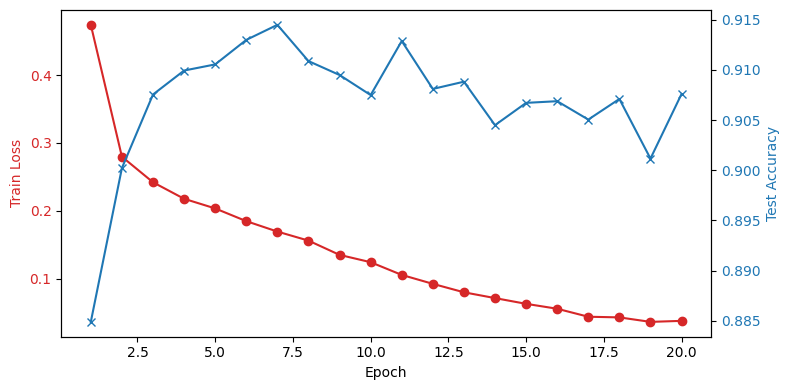

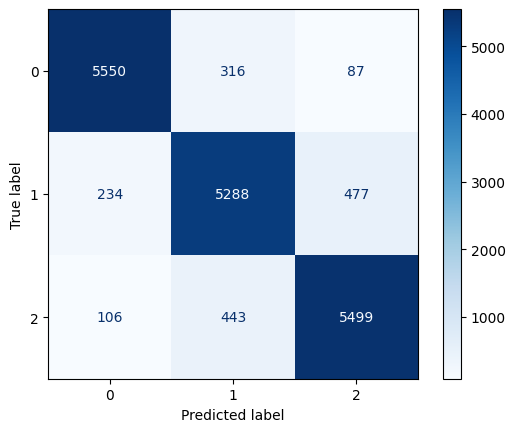

BiGRU Train Accuracy: 0.9076111111111111


In [41]:
gru_acc, gru_cm = train_model(model_gru, train_loader, test_loader, epochs=20, lr=1e-3)
print("BiGRU Train Accuracy:", gru_acc)

Evaluating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 563/563 [00:01<00:00, 544.29it/s]

Test Loss = 0.4937, Test Accuracy = 0.9076


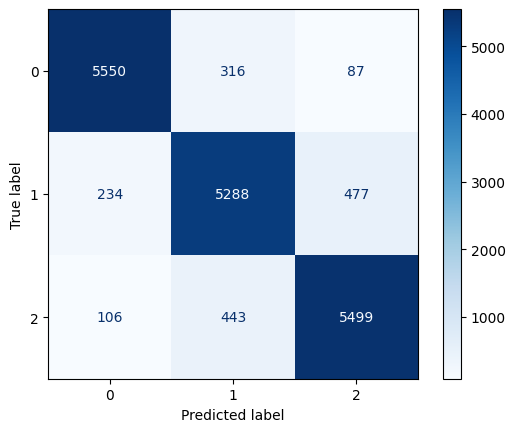

BiGRU Test Accuracy: 0.9076111111111111


In [42]:
test_acc, test_cm = evaluate(model_gru, test_loader)
print("BiGRU Test Accuracy:", test_acc)

**–û–±–∞ –≤–∞—Ä–∏–∞–Ω—Ç–∞ RNN, –∏ LSTM, –∏ GRU –ø—Ä–æ–¥–µ–º–æ–Ω—Å—Ç—Ä–∏—Ä–æ–≤–∞–ª–∏ –º–µ—Ç—Ä–∏–∫–∏ accuracy –≤—ã—à–µ 90%.**